In [1]:
import cv2
import numpy as np

def image_res(imagen, brillo_min=40, **kwargs):
    """
    Cleans the endoscopic image by removing the green box (ScopeGuide),
    cropping the bright useful region if applicable, and masking any green
    box by filling it with the average color (excluding green regions).
    """

    # Convert to LAB to detect brightness
    imagen_lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)
    l_channel, _, _ = cv2.split(imagen_lab)

    # Brightness threshold
    _, mask = cv2.threshold(l_channel, brillo_min, 255, cv2.THRESH_BINARY)

    # Erosion + dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Search for contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)
        if w * h < 0.95 * imagen.shape[0] * imagen.shape[1]:
            margen = 10
            x = max(x - margen, 0)
            y = max(y - margen, 0)
            x2 = min(x + w + 2 * margen, imagen.shape[1])
            y2 = min(y + h + 2 * margen, imagen.shape[0])
            imagen = imagen[y:y2, x:x2]
            mask = mask[y:y2, x:x2]

    # Convert to HSV
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    # Green range
    verde_bajo = np.array([35, 100, 100])
    verde_alto = np.array([85, 255, 255])

    mask_verde = cv2.inRange(hsv, verde_bajo, verde_alto)

    # Morphology to join disperse pixels
    kernel_verde = np.ones((15, 15), np.uint8)
    mask_verde = cv2.morphologyEx(mask_verde, cv2.MORPH_CLOSE, kernel_verde)
    mask_verde = cv2.dilate(mask_verde, kernel_verde, iterations=1)

    n_pixels_verdes = cv2.countNonZero(mask_verde)

    # Prepare mask to exclude green
    if cv2.countNonZero(mask) > 0:
        # Combine brightness mask and NOT green mask
        mask_no_verde = cv2.bitwise_and(mask, cv2.bitwise_not(mask_verde))
        if cv2.countNonZero(mask_no_verde) > 0:
            mean_color = cv2.mean(imagen, mask=mask_no_verde)[:3]
        else:
            # If everything is green, fallback to no-green over whole image
            mask_all_no_verde = cv2.bitwise_not(mask_verde)
            mean_color = cv2.mean(imagen, mask=mask_all_no_verde)[:3]
    else:
        # No brightness mask, use entire image excluding green
        mask_all_no_verde = cv2.bitwise_not(mask_verde)
        mean_color = cv2.mean(imagen, mask=mask_all_no_verde)[:3]

    mean_color = np.array(mean_color, dtype=np.uint8)

    if n_pixels_verdes > 0:
        relleno = np.full(imagen.shape, mean_color, dtype=np.uint8)
        mask_verde_3c = cv2.merge([mask_verde]*3)
        imagen_resultado = np.where(mask_verde_3c > 0, relleno, imagen)
        return imagen_resultado

    return imagen


In [3]:
from tensorflow.keras.utils import Sequence
import numpy as np


class AlbumentationsDataGenerator(Sequence):
    def __init__(self, image_paths, labels, transform, batch_size=32, num_classes=3, shuffle=True, target_size=(224,224)):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = []
        batch_labels = []
        for i in batch_indices:
            img = cv2.imread(self.image_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = self.transform(image=img)
            img = augmented['image'].astype(np.float32) / 255.0                   
            batch_images.append(img)
            batch_labels.append(self.labels[i])
        batch_images = np.array(batch_images)
        batch_labels = np.eye(self.num_classes)[batch_labels]
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

            batch_images.append(img)
            batch_labels.append(self.labels[i])
        batch_images = np.array(batch_images)
        batch_labels = np.eye(self.num_classes)[batch_labels]
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [7]:
import tensorflow as tf
import datetime
import cv2
import os
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
import glob

class_indices = {'esophagitis':0, 'polyps':1, 'ulcerative-colitis':2}

test_image_paths = []
test_labels = []

for class_name, idx in class_indices.items():
    files = glob.glob(f"splited_dataset/test/{class_name}/*")
    test_image_paths.extend(files)
    test_labels.extend([idx]*len(files))

test_transform = A.Compose([
    A.Lambda(image=image_res, p=1.0),
    A.Resize(224,224)
])

test_gen = AlbumentationsDataGenerator(
    image_paths=test_image_paths,
    labels=test_labels,
    transform=test_transform,
    batch_size=32,
    num_classes=3,
    shuffle=False
)

model = tf.keras.models.load_model("model_mobilenetV2_albumentation8.keras")

loss, acc = model.evaluate(test_gen, verbose=1)


C:\Users\valer\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9660 - loss: 0.1462


In [15]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Test Loss: 0.2026
Test Accuracy: 0.9489


In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

generator = test_gen  # val_gen

y_true = np.array(generator.labels)


y_pred_probs = model.predict(generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step



====== METRICS PER CLASS ======

Class 'esophagitis':
  Precision: 0.9434
  Recall: 1.0000
  F1 Score: 0.9709
  Specificity: 0.9700

Class 'polyps':
  Precision: 0.9926
  Recall: 0.9000
  F1 Score: 0.9441
  Specificity: 0.9967

Class 'ulcerative-colitis':
  Precision: 0.9161
  Recall: 0.9467
  F1 Score: 0.9311
  Specificity: 0.9567

======Confusion matrix========:


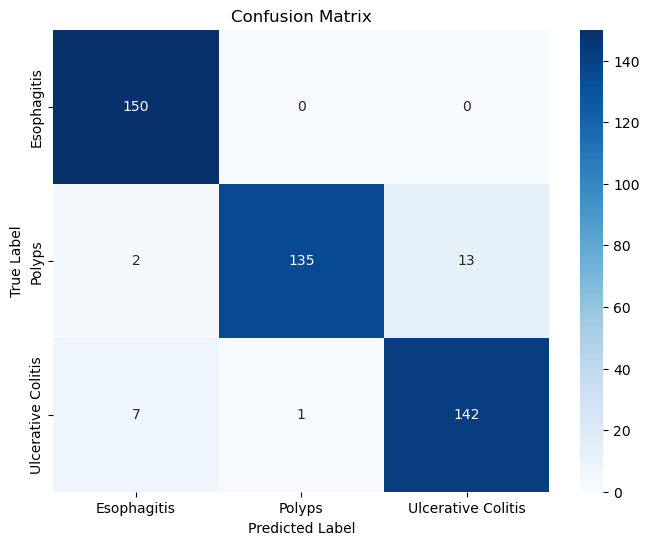

In [21]:
# Clases
classes = list(class_indices.keys())

# Precision por clase
precision_per_class = precision_score(y_true, y_pred, average=None)

# Recall por clase
recall_per_class = recall_score(y_true, y_pred, average=None)

# F1 por clase
f1_per_class = f1_score(y_true, y_pred, average=None)

cm = confusion_matrix(y_true, y_pred)
class_names = ['Esophagitis', 'Polyps', 'Ulcerative Colitis']

# Specificity por clase
specificity_per_class = []
for i in range(len(classes)):
    TN = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    FP = cm[:,i].sum() - cm[i,i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificity_per_class.append(specificity)

# Mostrar métricas por clase
print("\n====== METRICS PER CLASS ======")
for idx, cls in enumerate(classes):
    print(f"\nClass '{cls}':")
    print(f"  Precision: {precision_per_class[idx]:.4f}")
    print(f"  Recall: {recall_per_class[idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[idx]:.4f}")
    print(f"  Specificity: {specificity_per_class[idx]:.4f}")


print("\n======Confusion matrix========:")
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("\n====== GLOBAL METRICS ======")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")


====== GLOBAL METRICS ======
Accuracy: 0.9489
Precision (macro): 0.9507
Recall (macro): 0.9489
F1 Score (macro): 0.9487
